In [8]:
# standard libs
import os
import sys
import logging

# project lib
PROJECT_SRC_PATH = os.path.join(os.path.abspath(''), '..', 'src')
sys.path.append(PROJECT_SRC_PATH)

import utils
import dataset
import visualizations
from prediction_age import AgePredictor
from prediction_type import TypeClassifier
from preprocessing import *

# external libs
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely import wkt

import shap

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier
from xgboost import XGBRegressor, XGBClassifier, XGBRFClassifier

In [2]:
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
%load_ext autoreload
%autoreload 2

## Data

In [4]:
path_data_slovakia = os.path.join('..', 'data', 'df-slovakia.pkl')
data_slovakia = pd.read_pickle(path_data_slovakia)

In [5]:
df = data_slovakia.sample(frac=0.1)

In [ ]:
xgb_params_optimal = {
    'max_depth': 10,
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'colsample_bytree': 0.5,
    'subsample': 1.0,
}

## Preprocessing

In [6]:
df

,id,id_source,height,type_source,type,age,floors,source_file,id_misaligned,conditionOfConstruction,...,blocks_2_to_4,blocks_5_to_9,blocks_10_to_19,blocks_20_to_inf,intersections_count,total_length_street_city,av_length_street_city,total_number_block_city,av_area_block_city,std_area_block_city
2462449,v0.1-SVK.2.6_1-54787,BuildingP.881757,7.600,individual residence,residential,NaN,NaN,BuildingS,v0.1-SVK.2.6_1-54787,functional,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2445690,v0.1-SVK.2.6_1-38028,BuildingP.923641,3.500,agriculture,non-residential,NaN,NaN,BuildingS,v0.1-SVK.2.6_1-38028,unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
810,v0.1-SVK.4.6_1-810,BuildingP.944551,3.100,individual residence,residential,NaN,NaN,BuildingS,v0.1-SVK.4.6_1-810,functional,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3414359,v0.1-SVK.1.6_1-12952,BuildingP.1223345,8.100,individual residence,residential,NaN,NaN,BuildingS,v0.1-SVK.1.6_1-12952,functional,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3037606,v0.1-SVK.8.4_1-15681,BuildingP.2653336,3.000,unknown,NaN,NaN,NaN,BuildingS,v0.1-SVK.8.4_1-15681,unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1434248,v0.1-SVK.6.6_1-36296,BuildingP.2540555,5.300,ancillary,non-residential,NaN,NaN,BuildingS,v0.1-SVK.6.6_1-36296,functional,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3313795,v0.1-SVK.4.5_1-13586,BuildingP.254053,6.700,individual residence,residential,NaN,NaN,BuildingS,v0.1-SVK.4.5_1-13586,functional,...,1277.0,12.0,4.0,0.0,1457.0,480747.043101,253.024760,449.0,367008.932875,3.372711e+06
3076627,v0.1-SVK.2.7_1-34524,BuildingP.615870,7.000,individual residence,residential,NaN,NaN,BuildingS,v0.1-SVK.2.7_1-34524,unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
483397,v0.1-SVK.1.1_1-28671,BuildingP.2295210,7.800,industrial,non-residential,NaN,NaN,BuildingS,v0.1-SVK.1.1_1-28671,functional,...,7433.0,614.0,117.0,28.0,2841.0,806067.334259,231.961823,707.0,220011.539841,2.333143e+06


## Experiments

In [11]:
predictor = TypeClassifier(
    model=XGBClassifier(),
    labels=['residential', 'non-residential'],
    df=df.dropna(subset=['type']),
    test_training_split=split_80_20,
    preprocessing_stages=[]
)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2022-12-28 19:48:34,428 | INFO : Dataset length: 304806
2022-12-28 19:48:34,434 | INFO : Dataset allocated memory: 318 MB
2022-12-28 19:48:34,844 | INFO : No abort signal received. Continuing... To abort please create /Users/fnachtigall/workspace/ufo-prediction/metadata/local-ef21373a.abort.
2022-12-28 19:48:34,845 | INFO : Training dataset length: 243844
2022-12-28 19:48:34,845 | INFO : Test dataset length: 60962
2022-12-28 19:48:34,851 | INFO : Test cities: ['Dunajská Streda' 'Púchov' 'Trenčín' 'Košice-okolie' 'Považská Bystrica'
 'Žilina' 'Kežmarok' 'Komárno' 'Dolný Kubín' 'Ša

AttributeError: 'TypeClassifier' object has no attribute 'evaluate_regression'

Classification report:
                  precision    recall  f1-score  support
residential       0.835953  0.787304  0.810899    25741
non-residential   0.850895  0.887084  0.868613    35221
accuracy          0.844953  0.844953  0.844953        0
macro avg         0.843424  0.837194  0.839756    60962
weighted avg      0.844585  0.844953  0.844244    60962
Cohen’s kappa: 0.6797
Matthews correlation coefficient (MCC): 0.6806


FixedFormatter should only be used together with FixedLocator


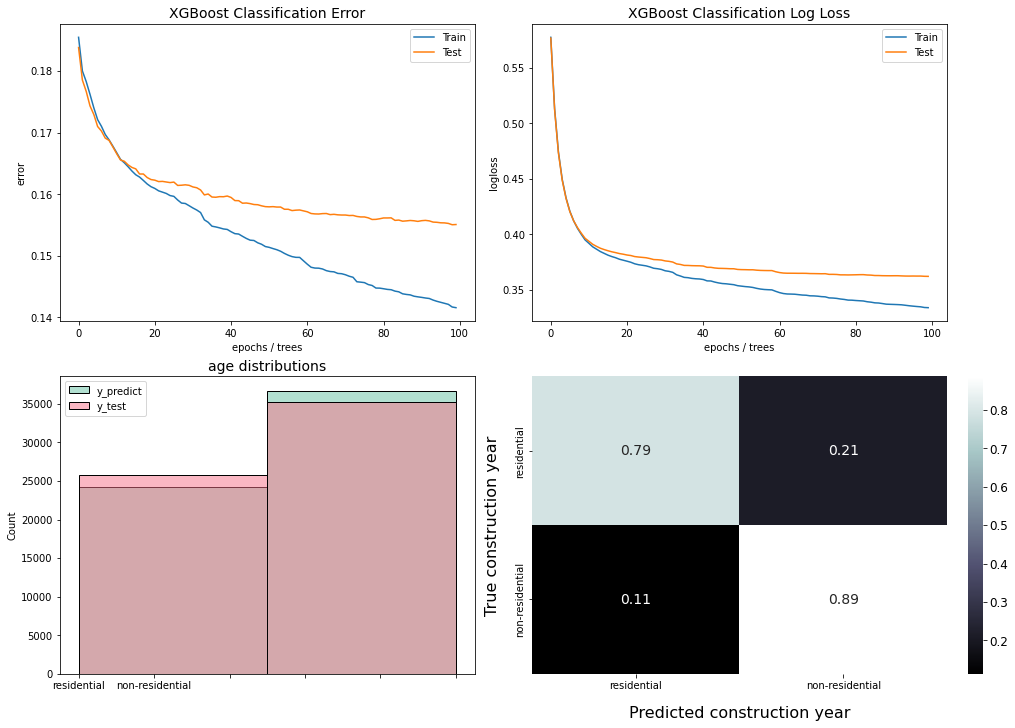

In [12]:
predictor.evaluate()